In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import time
import pickle

# cells defined in earlier notebooks

In [2]:
def R_nonbinding_3eq(y,t):
    """
    system of ODEs from Zaytsev 2016, simplified using two mass balances
    with the following components:
    - a: inactive Aurora B kinase
    - A: active Aurora B kinase
    - AA: enzyme-substrate complex of inactive + active Aurora B kinase
    - Ph: phosphatase
    - PhA: enzyme-substrate complex of phosphatase + active Aurora B kinase
    - a0: total Aurora B kinase
    - p0: total phosphatase
    """
    # set variable space
    A, AA, Ph = y
    
    # mass balances
    PhA = p0 - Ph
    a = a0 - A - 2*AA - PhA
    
    # reaction equations
    dAdt = (kcis - kfa*A)*a + (kra+2*kca)*AA - kfp*A*Ph + krp*PhA
    dAAdt = kfa*A*a - (kra+kca)*AA
    dPhdt = -kfp*A*Ph + (krp + kcp)*PhA
    
    return dAdt, dAAdt, dPhdt

In [3]:
"""
parameters from Zaytsev 2016
"""

kcis = 7.29*10**-6    # 1/s        # rate constant for 'in cis' Aurora B activation

kfa  = 0.1            # 1/(uM*s)   # rate constant for AA complex formation
kca  = 2.7*10**-2     # 1/s        # rate constant for AA catalysis
Kma  = 51             # uM         # Michaelis constant for AA 'in trans' activation
kra  = kfa*Kma-kca    # 1/         # rate constant for AA complex dissociation

kfp  = 0.6            # 1/(uM*s)   # rate constant for PhA complex formation
kcp  = 2.4*10**-2     # 1/s        # rate constant for PhA catalysis
Kmp  = 1.95           # uM         # Michaelis constant for PhA 'in trans' activation
krp  = kfp*Kmp-kcp    # 1/s        # rate constant for PhA complex dissociation

In [4]:
"""
algorithm to find high + low steady states 
for different phosphatase concentrations + 10 uM total kinase
uses zero for the low state in phosphatase concentrations with monostable high states
- to be used as initial active kinase concentrations for spatial simulations
"""
t = np.linspace(0,2000*60,2000*60)

a0 = 10

# build phosphatase concentration list
p0_range = [0,.2]
for n in np.arange(.4,.61,.01):
    p0_range.append(round(n,2))

# temporal evolution to find steady state concentrations with low initial kinase activity
lo_ss_nbns = []
for p0 in p0_range:
    y = odeint(R_nonbinding_3eq,[0,0,p0],t)
    A, aA, Ph = y[-1,:]
    
    # use zero initial active kinase for points with monostable high states
    if A > 1:
        lo_ss_nbns.append((str(p0),0,a0,0,p0,0))
    else:
        PhA = p0 - Ph
        a = a0-A-2*aA-PhA
        lo_ss_nbns.append((str(p0),A, a, aA, Ph, PhA))

# temporal evolution to find steady state concentrations with high initial kinase activity
hi_ss_nbns = []
for p0 in p0_range:
    y = odeint(R_nonbinding_3eq,[a0,0,p0],t)
    A, aA, Ph = y[-1,:]
    PhA = p0 - Ph
    a = a0-A-2*aA-PhA
    hi_ss_nbns.append((str(p0),A, a, aA, Ph, PhA))

In [5]:
def mesh_fourier(zmin,zmax,nz):
    """
    discrete approximation of the spatial derivative operator (Laplacian)
    uses spectral symmetry to simplify operations, forces periodic boundary conditions
    """
    dz = np.zeros((nz,nz))
    for i in range(nz):
        for j in range(nz):
            if i == j:
                dz[i,i] = 0
            else:
                dz[i,j] = np.pi*(-1)**((i-1)+(j-1))/(zmax-zmin)/np.tan(((i-1)-(j-1))*np.pi/(nz))
    return dz

In [6]:
def R_nonbinding_5eq(y,t):
    """
    system of ODEs from Zaytsev 2016, without simplifications
    """
    # unpack species profiles
    A, a, aA, Ph, PhA = y

    # calculate reaction equations
    dadt = -(kcis + kfa*A)*a + kra*aA + kcp*PhA
    dAdt = (kcis - kfa*A)*a + (kra + 2*kca)*aA - kfp*A*Ph + krp*PhA
    daAdt = kfa*A*a - (kra + kca)*aA 
    dPhdt = -kfp*A*Ph + (krp + kcp)*PhA
    dPhAdt = -dPhdt
    
    # output concentration changes
    return dAdt, dadt, daAdt, dPhdt, dPhAdt

In [7]:
def spatial_simulation_nonbind_ss_perturb(lo_ss,hi_ss,t_end,dt,t_save,L,N,perturb_width):
    """
    reaction-diffusion algorithm with a perturbed center width as initial conditions
    combines the above kinase-phosphatase reaction network + simple diffusion algorithm
    """
    # extract the information from the initial condition array function inputs
    lostr, A0_lo, a0_lo, aA0_lo, Ph0_lo, PhA0_lo = lo_ss
    histr, A0_hi, a0_hi, aA0_hi, Ph0_hi, PhA0_hi = hi_ss
    
    # initilize perturbed conditions for each reacting species
    A = np.ones(N)*A0_lo
    A[round(N/2-perturb_width/2):round(N/2+perturb_width/2)] = np.ones(perturb_width)*A0_hi
    a = np.ones(N)*a0_lo
    a[round(N/2-perturb_width/2):round(N/2+perturb_width/2)] = np.ones(perturb_width)*a0_hi
    aA = np.ones(N)*aA0_lo
    aA[round(N/2-perturb_width/2):round(N/2+perturb_width/2)] = np.ones(perturb_width)*aA0_hi
    Ph = np.ones(N)*Ph0_lo
    Ph[round(N/2-perturb_width/2):round(N/2+perturb_width/2)] = np.ones(perturb_width)*Ph0_hi
    PhA = np.ones(N)*PhA0_lo
    PhA[round(N/2-perturb_width/2):round(N/2+perturb_width/2)] = np.ones(perturb_width)*PhA0_hi
    
    # combine species profiles into a single variable
    y = A, a, aA, Ph, PhA
    
    A_arr = np.zeros((N,round(t_end/t_save)+1))
    t_vec = np.zeros(round(t_end/t_save)+1)
    
    A_arr[:,0] = A
    
    dz = mesh_fourier(0,L,N)
    dz2 = np.dot(dz,dz)
    
    counter = 0
    counter_save = 0
    t = 0
    
    for i in range(round(t_end/dt)+1):
        counter += 1
        
        # solve reaction equations
        dy = R_nonbinding_5eq(y,t)
        
        # evolve species profiles according to reaction + diffusion
        A += dt*( dy[0] + D*np.dot(dz2,A) )   # dA/dt = R(A,a,aA,Ph,PhA) + D * dA^2/dz^2
        a += dt*( dy[1] + D*np.dot(dz2,a) )
        aA += dt*( dy[2] + D*np.dot(dz2,aA) )
        Ph += dt*( dy[3] + D*np.dot(dz2,Ph) )
        PhA += dt*( dy[4] + D*np.dot(dz2,PhA) )
        
        y = A, a, aA, Ph, PhA
        
        t += dt
        
        if counter == round(t_save/dt):
            counter = 0
            counter_save += 1
            
            A_arr[:,counter_save] = A
            t_vec[counter_save] = t
        
        arrays = A_arr,t_vec
        y = A, a, aA, Ph, PhA
    
    # output saved data arrays + last concentration profile variable in case extension is desired
    return arrays, y

# measuring traveling front propagation speed

In [8]:
"""
parameters for the following simulation
"""
t_end = 200*60
dt = 0.1
t_save = 1

N = 400
L = 1000
x_span = np.linspace(-L/2,L/2,N)

D = 1

# actual simulated perturbation width = (pw+1) * L / (N-1) = 41*1000/399 ~ 102.8 um
# the difference between two values is one less than all points inclusive
# e.g. there are 7 points between -3 and 3
pw = 40
print(f'actual pw: {round(x_span[int(N/2+pw/2)]*2,1)} um')

actual pw: 102.8 um


In [9]:
"""
simulates ~100 um perturbations with different phosphatase concentrations
- high perturbation width chosen to ensure resulting fully-developed traveling fronts
"""
start = time.time()
## algorithm takes ~4 min

# phosphatase concentrations (uM):
# 0, 0.4, 0.5, 0.55, 0.57, 0.6
idxs = [0,2,12,17,19,22]

perturb_100um = []
for idx in idxs:
    print(f'P = {lo_ss_nbns[idx][0]} uM')
    
    arrays, y = spatial_simulation_nonbind_ss_perturb(lo_ss_nbns[idx],hi_ss_nbns[idx],t_end,dt,t_save,L,N,pw)
    A_arr, t_vec = arrays

    perturb_100um.append((idx,A_arr))
    
pickle.dump(perturb_100um,open('perturb_100um','wb'))

end = time.time()
print(f'~ {round( (end - start)/60, 1 )} min')

actual pw: 102.8 um
P = 0 uM
P = 0.4 uM
P = 0.5 uM
P = 0.55 uM
P = 0.57 uM
P = 0.6 uM
~ 3.9 min


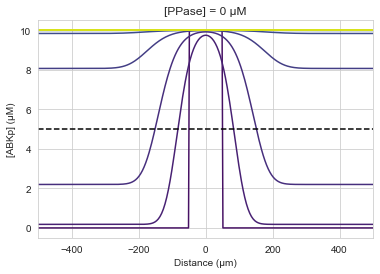

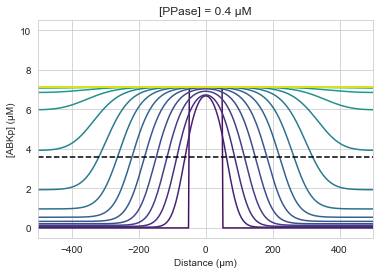

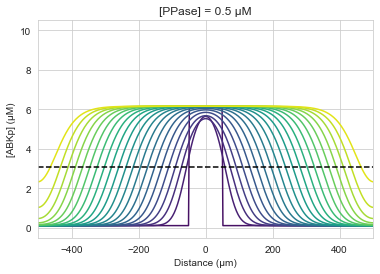

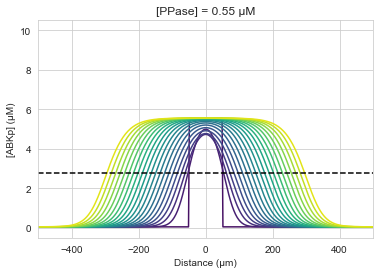

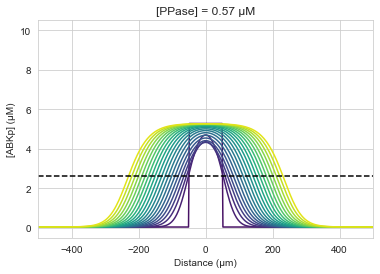

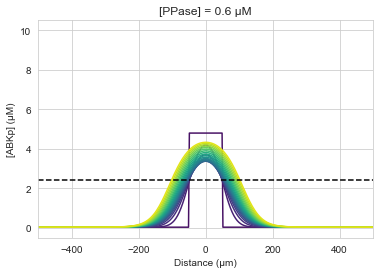

In [9]:
"""
Figure 12B + Supplemental Figure 11
plots time evolution of spatial profiles of each simulation
in relation to 50% high steady state active kinase levels (50% phosphorylation)

- when the central region reaches the high steady state: 
fully-developed traveling front, diffusion balancing activation
- for PPase = [0, 0.4] uM, traveling front is eventually subsumed by activation of the outer regions
- for PPase = 0.5 uM, boundary effects at the simulation edges eventually affects front speed
"""

perturb_100um = pickle.load(open('perturb_100um','rb'))

for idx,A_arr in perturb_100um:
    
    lin_range = range(0,len(A_arr[0,:]),10*60)
    colors = sns.color_palette('viridis', n_colors=len(lin_range))
        
    for n,i in enumerate(lin_range):
        plt.plot(x_span,A_arr[:,i],color=colors[n])
    plt.xlabel('Distance (\u03BCm)')
    plt.ylabel('[ABKp] (\u03BCM)')
    plt.title(f'[PPase] = {lo_ss_nbns[idx][0]} \u03BCM')
    plt.ylim(-.5,10.5)
    plt.locator_params(axis='y', nbins=6)
    plt.xlim(-L/2,L/2)
    
    # plots half the high steady state active kinase concentration as horizontal line
    # the time the spatial profile crosses this line is the data plotted in the next figures
    c_50 = hi_ss_nbns[idx][1]/2
    plt.axhline(c_50,color='k',linestyle='--')
    plt.show()

In [10]:
def find_nearest(array, value):
    """
    returns location of point nearest to input value within input array
    used for reconstructing Fig. 7B from Zaytsev, 2016
    where "time to 50% phosphorylation" is found by searching spatial profiles 
    for half the high steady state active kinase concentration
    """
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

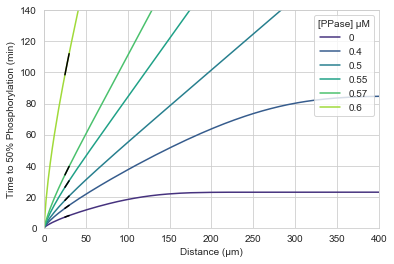

In [11]:
"""
Supplemental Figure 10
plots time taken to reach 50% high kinase activity (50% phosphorylation) for each simulation
as a function of the distance from the perturbation boundary

black line segments represent fully-developed traveling fronts 
that have not reached the boundary or have not been subsumed by activation in the outer region
- linear travel speed is a key feature of traveling fronts
"""

colors = sns.color_palette('viridis', n_colors=len(perturb_100um))

for n,(idx,A_arr) in enumerate(perturb_100um):
    
    c_50 = hi_ss_nbns[idx][1]/2
    
    # searches active kinase profile for value closest to the 50% phosphorylation level
    # builds curve of these values for every spatial point
    t_50 = []
    for i in range(len(x_span)):
        t_50.append(find_nearest(A_arr[i,:],c_50)[1]/60)

    # plots this curve starting from the perturbation boundary 
    # normalized to the values at the perturbation boundary
    plt.plot(x_span[int(N/2+pw/2):] - x_span[int(N/2+pw/2)], 
             t_50[int(N/2+pw/2):] - t_50[int(N/2+pw/2)],
             label = f'{lo_ss_nbns[idx][0]}',
             color = colors[n])
    
    # plots line segments with length 3, offset from the origin of the plotted curves by 10
    offset = 10
    plt.plot(x_span[int(N/2+pw/2+offset):int(N/2+pw/2+offset+3)] - x_span[int(N/2+pw/2)], 
             t_50[int(N/2+pw/2+offset):int(N/2+pw/2+offset+3)] - t_50[int(N/2+pw/2)],'k')

plt.xlabel('Distance (\u03BCm)')
plt.ylabel('Time to 50% Phosphorylation (min)')
plt.legend(title='[PPase] \u03BCM',loc='upper right')
plt.ylim(0,140)
plt.xlim(0,400);

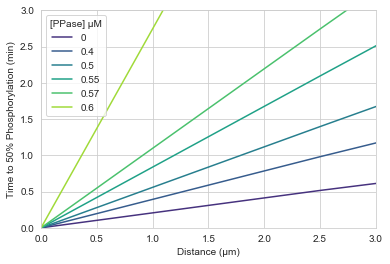

In [12]:
"""
Figure 12C
plots black line segments from above plot to directly relate to Fig 7B in Zaytsev 2016
describes linearly propagating traveling front speed at different phosphatase concentrations
- greater PPase concentration : slower front speed
"""

colors = sns.color_palette('viridis', n_colors=len(perturb_100um))

for n,(idx,A_arr) in enumerate(perturb_100um):
    
    t_50 = []
    c_50 = hi_ss_nbns[idx][1]/2
    for i in range(len(x_span)):
        t_50.append(find_nearest(A_arr[i,:],c_50)[1]/60)
    
    # plots the curve starting from the perturbation boundary + offset by 10
    # normalized to the values at the offset starting point
    offset = 10
    plt.plot(x_span[int(N/2+pw/2+offset):] - x_span[int(N/2+pw/2+offset)], 
            t_50[int(N/2+pw/2+offset):] - t_50[int(N/2+pw/2+offset)],
            label = f'{lo_ss_nbns[idx][0]}',
            color=colors[n])

plt.xlabel('Distance (\u03BCm)')
plt.ylabel('Time to 50% Phosphorylation (min)')
plt.legend(title='[PPase] \u03BCM')
plt.xlim(0,3)
plt.ylim(0,3);

In [13]:
"""
simulates ~10 um perturbations with different phosphatase concentrations
- perturbation width chosen to correspond to the width of chromosomal kinase binding sites
"""
start = time.time()
## algorithm takes <1 min

t_end = 80*60
dt = 0.1
t_save = 1

N = 400
L = 500
x_span = np.linspace(-L/2,L/2,N)

D = 1

# phosphatase concentrations (uM):
# 0.46, 0.5
idxs = [4,8,12]

# actual simulated perturbation width = (pw+1) * L / (N-1) = 9*500/399 ~ 11.3 um
pw = 8
print(f'actual pw: {round(x_span[int(N/2+pw/2)]*2,1)} um')

perturb_10um = []
for idx in idxs:
    print(f'P = {lo_ss_nbns[idx][0]} uM')
    
    arrays, y = spatial_simulation_nonbind_ss_perturb(lo_ss_nbns[idx],hi_ss_nbns[idx],t_end,dt,t_save,L,N,pw)
    A_arr, t_vec = arrays

    perturb_10um.append((idx,A_arr))

end = time.time()
print(f'~ {round( (end - start)/60, 1 )} min')

actual pw: 11.3 um
P = 0.42 uM
P = 0.46 uM
P = 0.5 uM
~ 0.9 min


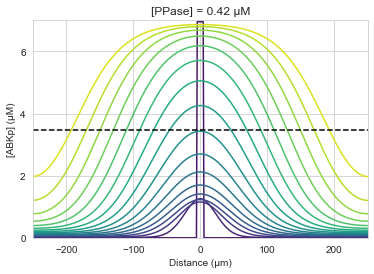

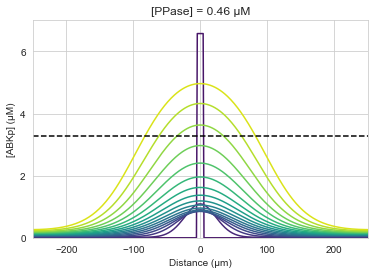

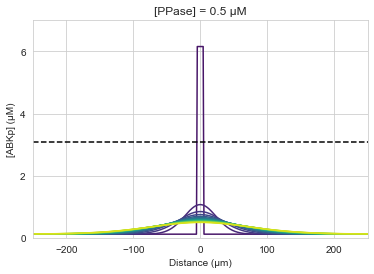

In [14]:
"""
Supplemental Figure 12
plots time evolution of spatial profiles of each simulation
in relation to 50% high steady state phosphorylation active kinase levels

- traveling fronts operate on the scale of hundreds of micrometers,
regardless of initial perturbation
    - thus are irrelevant on the <10 um scale of chromosomes, using the data provided by Zaytsev 2016
    - diffusion speed > reaction speed : comparison/verification of calculations are shown below
- traveling fronts within the bistable region (PPase >= 0.5 uM, shown by Supp Fig 13 in 6.1's Notebook) 
cannot produce a traveling front from a 10 um perturbation
"""

for idx,A_arr in perturb_10um:
    
    lin_range = range(0,len(A_arr[0,:]),5*60)
    colors = sns.color_palette('viridis', n_colors=len(lin_range))
        
    for n,i in enumerate(lin_range):
        plt.plot(x_span,A_arr[:,i],color=colors[n])
    plt.xlabel('Distance (\u03BCm)')
    plt.ylabel('[ABKp] (\u03BCM)')
    plt.title(f'[PPase] = {lo_ss_nbns[idx][0]} \u03BCM')
    plt.ylim(0,7)
    plt.locator_params(axis='y', nbins=6)
    plt.xlim(-L/2,L/2)
    
    c_50 = hi_ss_nbns[idx][1]/2
    plt.axhline(c_50,color='k',linestyle='--')
    plt.show()

# kinase diffusion speed from chromosomal binding sites

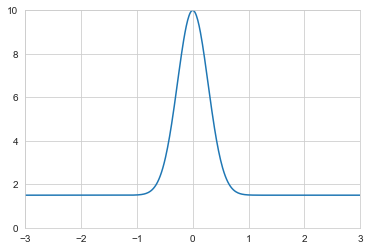

In [27]:
"""
plots Gaussian to represent an initial kinase condition equal to 
the binding site profile along a chromosome
as shown in Figure 6 - Supplement 1C, Zaytsev 2016
"""

L = 6
N = 500
x = np.linspace(-L/2, L/2, N)

Atot = 10

A = (Atot-1.5) * np.exp(- Atot / 1.5 * x**2) + 1.5
plt.plot(x,A)
plt.xlim(-L/2,L/2)
plt.ylim(0,10);

In [28]:
"""
simulates 5 seconds of diffusion from an initial chromosomal bound kinase profile
using the spectral / fourier mesh method
"""
start = time.time()
## algorithm takes <1 min

t_end = 5.01
dt = 0.00001
t_save = 0.1

D = 1

# initialize saved data arrays
A_arr = np.zeros((N,round(t_end/t_save)+1))
t_vec = np.zeros(round(t_end/t_save)+1)

A_arr[:,0] = A

dz = mesh_fourier(0,L,N)
dz2 = np.dot(dz,dz)

# initialize time/counters
t = 0
counter = 0
counter_save = 0

# loop over succesive time points and evolve system at each step
for i in range(round(t_end/dt)+1):
    counter += 1

    # update concentration change + time step
    A += dt*D*np.dot(dz2,A)
    t += dt

    # save output every {t_save} min, or {t_save/dt} iterations
    if counter == round(t_save/dt):
        counter = 0
        counter_save += 1

        A_arr[:,counter_save] = A
        t_vec[counter_save] = t
        
end = time.time()
print(f'~ {round( (end - start)/60, 1 )} min')

~ 0.8 min


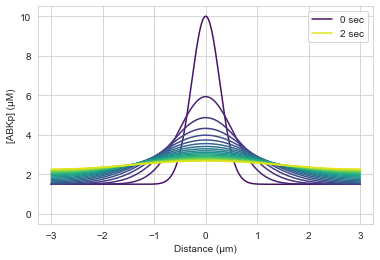

In [29]:
"""
Figure 13A + Supplemental Figure 22A
plots time evolution from above algorithm
- shows complete diffusion from an initial chromosome bound profile within 2 seconds
- spatial derivative methods are compared in supplemental Figure 22A
    - here, the spectral (fourier mesh) vs. central difference (zero flux) below
"""

end = 21
colors = sns.color_palette('viridis', n_colors=end)

for i in range(0,end):
    if i == 0 or i == 20:
        plt.plot(x,A_arr[:,i], color=colors[i], label=f'{int(t_vec[i])} sec')
    else:
        plt.plot(x,A_arr[:,i], color=colors[i])
plt.legend()
plt.ylim(-.5,10.5)
plt.xlim(-3.25,3.25)
plt.ylabel('[ABKp] (\u03BCM)')
plt.xlabel('Distance (\u03BCm)');

In [30]:
def laplacian1D_Neumann(a, dx):
    """
    computes the spatial derivative via central difference + Neumann boundary conditions
    """
    # cent.diff. over entire spatial interval
    La = ( np.roll(a,-1,axis=0) + np.roll(a,1,axis=0) - 2*a ) / (dx**2)
    # boundary conditions where d/dx(a) at x=0, L=0
    La[0] = ( a[1] - a[0] ) / (dx**2)
    La[-1] = ( a[-2] - a[-1] ) / (dx**2)
    return La

In [34]:
"""
simulates 5 seconds of diffusion from an initial chromosomal bound kinase profile
using the central difference / zero flux method
"""
start = time.time()
## algorithm takes <1 min

D = 1

t_end = 5.01
dt = 0.00001
t_save = 0.1

L = 6
N = 500
dx = L/N
x = np.linspace(-L/2, L/2, N)

Atot = 10
A = (Atot-1.5) * np.exp(- Atot / 1.5 * x**2) + 1.5

# initialize saved data arrays
A_arr = np.zeros((N,round(t_end/t_save)+1))
t_vec = np.zeros(round(t_end/t_save)+1)

A_arr[:,0] = A

# initialize time/counters
t = 0
counter = 0
counter_save = 0

# loop over succesive time points and evolve system at each step
for i in range(round(t_end/dt)+1):
    counter += 1
    
    # calculate spatial derivatives
    La = laplacian1D_Neumann(A,dx)
    
    # update concentration change + time step
    A += dt*(D * La)
    t += dt

    # save output every {t_save} min, or {t_save/dt} iterations
    if counter == round(t_save/dt):
        counter = 0
        counter_save += 1

        A_arr[:,counter_save] = A
        t_vec[counter_save] = t
        
end = time.time()
print(f'~ {round( (end - start)/60, 1 )} min')

~ 0.7 min


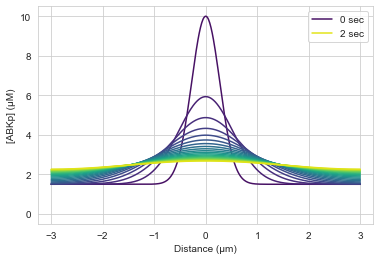

In [35]:
"""
Supplemental Figure 22B
plots time evolution from above algorithm
- here, the central difference (zero flux) is idential to the spectral (fourier mesh) above
"""

end = 21
colors = sns.color_palette('viridis', n_colors=end)

for i in range(0,end):
    if i == 0 or i == 20:
        plt.plot(x,A_arr[:,i], color=colors[i], label=f'{int(t_vec[i])} sec')
    else:
        plt.plot(x,A_arr[:,i], color=colors[i])
plt.legend()
plt.ylim(-.5,10.5)
plt.xlim(-3.25,3.25)
plt.ylabel('[ABKp] (\u03BCM)')
plt.xlabel('Distance (\u03BCm)');

# activation speed : significantly slower than diffusion

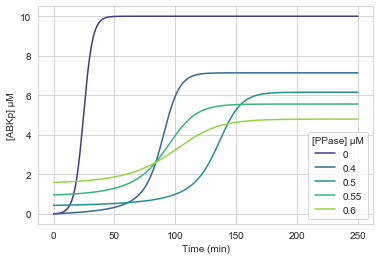

In [20]:
"""
Figure 13B
simulates the tens to hundreds of minutes required for kinase activation
- compared with the < 5 second diffusion timescale, activation is much slower
- since diffusion speed >> activation speed, traveling fronts in this system must be wide
    - a chromosomal profile is too narrow to support traveling fronts,
    as determined by parameters in Zaytsev 2016
"""

t = np.linspace(0,250*60,10000)

a0 = 10
a = 0

colors = sns.color_palette('viridis', n_colors=5)

for n,p0 in enumerate([0,.4,.5,.55,.6]):
    A0 = [a,0,p0]
    y = odeint(R_nonbinding_3eq,A0,t)
    while y[-1,0] < 1:
        a += 0.1
        A0 = [a,0,p0]
        y = odeint(R_nonbinding_3eq,A0,t)
        
    plt.plot(t[1:]/60,y[:,0][1:], label=f'{p0}', color=colors[n])

plt.legend(title='[PPase] \u03BCM',loc='lower right')
plt.ylabel('[ABKp] \u03BCM')
plt.xlabel('Time (min)');

# verification of diffusion + reaction calculations

In [21]:
"""
verification of diffusion calculation by comparing to
Figure 3B (bottom) in Gelens et al. (2014). MBoC, 25(22), 3486-3493.
simulation uses a FitzHugh-Nagumo (FHN) reaction system
"""

def spatial_simulation_FHN(pw,t_end,dt,t_save,N,L):
    
    x = np.linspace(-L/2, L/2, N)
    
    u = -0.6*np.ones(N)
    v = -0.3*np.ones(N)
    
    u[round(N/2-pw/2):round(N/2+pw/2)] = np.ones(pw)
    
    # initialize saved data arrays
    U_arr = np.zeros((N,round(t_end/t_save)+1))
    V_arr = np.zeros((N,round(t_end/t_save)+1))
    t_vec = np.zeros(round(t_end/t_save)+1)
    
    U_arr[:,0] = u
    V_arr[:,0] = v
    
    dz = mesh_fourier(0,L,N)
    dz2 = np.dot(dz,dz)
    
    counter = -1
    counter_save = 0
    
    # loop over succesive time points and evolve system at each step
    for i in range(round(t_end/dt)+1):
        counter += 1
        
        # solve equations 
        du, dv = FHN(u,v)
        
        u = u + dt*(du + D*np.dot(dz2,u))
        v = v + dt*(dv + D*np.dot(dz2,v))
        
        t = i*dt
        
        # save output every {t_save} min, or {t_save/dt} iterations
        if counter == round(t_save/dt):
            counter = 0
            counter_save += 1
            
            U_arr[:,counter_save] = u
            V_arr[:,counter_save] = v
        
    return U_arr,V_arr,t_vec

In [22]:
"""
FitzHugh-Nagumo reaction system
"""
def FHN(U,V):
    dU = U - Bist*U**3 - V
    dV = eps*(U - b*V + a)
    return dU, dV

In [24]:
"""
FitzHugh-Nagumo + simulation parameters
"""

a = 0.1
b = 2
eps = 0.01
Bist = 1
D = 1

t_end = 400
dt = 0.1
N = 400 #number of discretization points
L = 400 # domain size
t_save = 1
pw = 40

U_arr,V_arr,t_vec = spatial_simulation_FHN(pw,t_end,dt,t_save,N,L)

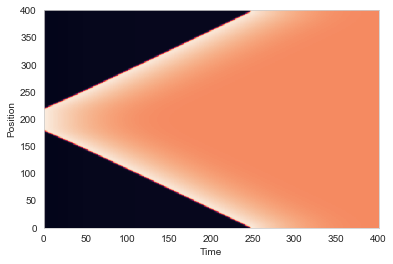

In [25]:
"""
Supplemental Figure 14B
spatiotemporal heatmap of above algorithm
- compares with Gelens 2014 exactly, thus the rxn-diff calculation system is validated
"""

plt.pcolor(U_arr)
plt.xlabel('Time')
plt.ylabel('Position');

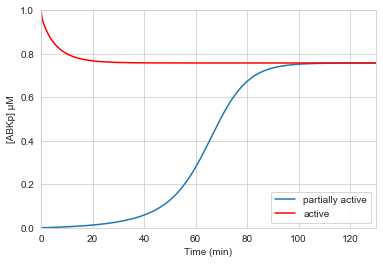

In [26]:
"""
Supplemental Figure 15B
verification of reaction calculation by comparing to Figure 4B, Zaytsev 2016
time evolution initialized with active + partially active (inactive) kinase levels
- compares with Fig 4B, thus the reaction kinetic calculations are validated
"""

t = np.linspace(0,200*60,500)

a0 = 8
p0 = .25

A0 = [0,0,p0]
y_part_active = odeint(R_nonbinding_3eq,A0,t)

A0 = [a0,0,p0]
y_active = odeint(R_nonbinding_3eq,A0,t)

plt.plot(t/60,y_part_active[:,0]/a0, label='partially active')
plt.plot(t/60,y_active[:,0]/a0, label='active', color='r')
plt.legend(loc='lower right')
plt.ylabel('[ABKp] \u03BCM')
plt.xlabel('Time (min)')
plt.ylim(0,1)
plt.xlim(0,130);